In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Activation

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [31]:
base_model_vg = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model_vg.trainable = False

In [32]:
from tensorflow.keras.regularizers import l2

In [6]:
# # ver2
# inputs = Input(shape=(224,224,3))
# x = base_model_vg(inputs, training=False)
# x = Flatten()(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# outputs = Dense(4, activation='softmax')(x)

In [7]:
# # ver 3
# inputs = Input(shape=(224, 224, 3))
# x = base_model_vg(inputs, training=False)
# x = Flatten()(x)
# x = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
# outputs = Dense(4, activation='softmax')(x)

In [8]:
# # ver 4
# inputs = Input(shape=(224, 224, 3))
# x = base_model_vg(inputs, training=False)
# x = Flatten()(x)
# x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
# outputs = Dense(4, activation='softmax')(x)

In [33]:
# # ver 5
# inputs = Input(shape=(224, 224, 3))
# x = base_model_vg(inputs, training=False)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
# outputs = Dense(4, activation='softmax')(x)

In [ ]:
# ver 6
inputs = Input(shape=(224, 224, 3))
x = base_model_vg(inputs, training=False)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

In [34]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1605696   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                           

In [10]:
root_path = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
test_path = '/kaggle/working/test'
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

In [11]:
import os
import shutil
import random


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
for class_folder in os.listdir(root_path):
    class_path = os.path.join(root_path, class_folder)
    if os.path.isdir(class_path):
        class_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]
        print(f"{len(class_files)} images found in {class_folder}")
        train_images, temp_images = train_test_split(class_files, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.6, random_state=42)
        train_class_path = os.path.join(train_path, class_folder)
        val_class_path = os.path.join(val_path, class_folder)
        test_class_path = os.path.join(test_path, class_folder)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)
        for image_name in train_images:
            src_path = os.path.join(class_path, image_name)
            dst_path = os.path.join(train_class_path, image_name)
            shutil.copy(src_path, dst_path)
        for image_name in test_images:
            src_path = os.path.join(class_path, image_name)
            dst_path = os.path.join(test_class_path, image_name)
            shutil.copy(src_path, dst_path)
        for image_name in val_images:
            src_path = os.path.join(class_path, image_name)
            dst_path = os.path.join(val_class_path, image_name)
            shutil.copy(src_path, dst_path)


3709 images found in Cyst
2283 images found in Tumor
1377 images found in Stone
5077 images found in Normal


In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import math

In [35]:
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

# train_datagen = ImageDataGenerator(
#     rotation_range=10,          
#     width_shift_range=0.05,      
#     height_shift_range=0.05,     
#     shear_range=0.05,            
#     zoom_range=0.05,             
#     horizontal_flip=True,
#     fill_mode='nearest',
#     rescale=1./255
# )


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode ='sparse',
    shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode ='sparse',
    shuffle=False,
)


Found 8710 images belonging to 4 classes.
Found 1493 images belonging to 4 classes.
Found 2243 images belonging to 4 classes.


In [37]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
import numpy as np

In [39]:
class_labels = np.unique(train_generator.classes)
class_counts = np.bincount(train_generator.classes)
class_weights = len(train_generator.classes) / (len(class_labels) * class_counts)
class_weights_dict = dict(zip(class_labels, class_weights))

In [ ]:
# # no l2 regularization to prevenet overfitting
# history = model.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // BATCH_SIZE,
#     validation_data=val_generator,
#     validation_steps = val_generator.samples // BATCH_SIZE,
#     epochs=10,
#     callbacks=[lr_scheduler, early_stopping]
# )

In [ ]:
# # with l2 regularization
# history = model.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // BATCH_SIZE,
#     validation_data=val_generator,
#     validation_steps = val_generator.samples // BATCH_SIZE,
#     epochs=10,
#     callbacks=[lr_scheduler, early_stopping]
# )

In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // BATCH_SIZE,
#     validation_data=val_generator,
#     validation_steps = val_generator.samples // BATCH_SIZE,
#     epochs=10,
#     callbacks=[lr_scheduler, early_stopping]
# )

In [ ]:
# # inputs = Input(shape=(224, 224, 3))
# # x = base_model_vg(inputs, training=False)
# # x = Flatten()(x)
# # x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
# # x = BatchNormalization()(x)
# # x = Dropout(0.4)(x)
# # outputs = Dense(4, activation='softmax')(x)
# history = model.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // BATCH_SIZE,
#     validation_data=val_generator,
#     validation_steps = val_generator.samples // BATCH_SIZE,
#     epochs=10,
#     callbacks=[lr_scheduler, early_stopping]
# )

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs=15,
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)

Epoch 1/15
272/272 [==============================] - 151s 513ms/step - loss: 1.8131 - accuracy: 0.5085 - val_loss: 1.4643 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 2/15
272/272 [==============================] - 141s 518ms/step - loss: 1.3469 - accuracy: 0.6087 - val_loss: 1.1556 - val_accuracy: 0.6624 - lr: 0.0010
Epoch 3/15
272/272 [==============================] - 142s 521ms/step - loss: 1.3074 - accuracy: 0.6050 - val_loss: 1.1115 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 4/15
272/272 [==============================] - 141s 518ms/step - loss: 1.2637 - accuracy: 0.6133 - val_loss: 0.9147 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 5/15
272/272 [==============================] - 141s 518ms/step - loss: 1.2408 - accuracy: 0.6309 - val_loss: 1.1850 - val_accuracy: 0.5836 - lr: 0.0010
Epoch 6/15
272/272 [==============================] - 141s 517ms/step - loss: 1.2676 - accuracy: 0.6065 - val_loss: 1.1247 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 7/15
272/272 [==========================

In [ ]:
# history2 = model.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // BATCH_SIZE,
#     validation_data=val_generator,
#     validation_steps = val_generator.samples // BATCH_SIZE,
#     epochs=10,
#     callbacks=[lr_scheduler, early_stopping]
# )

In [40]:
# # ver 5
# inputs = Input(shape=(224, 224, 3))
# x = base_model_vg(inputs, training=False)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
# outputs = Dense(4, activation='softmax')(x)
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs=15,
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)

Epoch 1/15
272/272 [==============================] - 143s 520ms/step - loss: 1.1434 - accuracy: 0.5310 - val_loss: 0.9742 - val_accuracy: 0.6039 - lr: 0.0010
Epoch 2/15
272/272 [==============================] - 141s 519ms/step - loss: 0.8402 - accuracy: 0.6646 - val_loss: 0.4885 - val_accuracy: 0.8179 - lr: 0.0010
Epoch 3/15
272/272 [==============================] - 141s 519ms/step - loss: 0.7593 - accuracy: 0.7127 - val_loss: 0.5917 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 4/15
272/272 [==============================] - 140s 514ms/step - loss: 0.6904 - accuracy: 0.7357 - val_loss: 0.4800 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 5/15
272/272 [==============================] - 140s 515ms/step - loss: 0.6754 - accuracy: 0.7423 - val_loss: 0.4439 - val_accuracy: 0.8485 - lr: 0.0010
Epoch 6/15
272/272 [==============================] - 140s 515ms/step - loss: 0.6266 - accuracy: 0.7596 - val_loss: 0.3305 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 7/15
272/272 [==========================

In [41]:
test_loss, test_accuray = model.evaluate(test_generator)
print('Test Loss: ',test_loss)
print('Test Accuracy: ', test_accuray)

71/71 [==============================] - 9s 122ms/step - loss: 0.2742 - accuracy: 0.9028
Test Loss:  0.2741810083389282
Test Accuracy:  0.9028087258338928


In [42]:
from matplotlib import pyplot as plt
%matplotlib inline

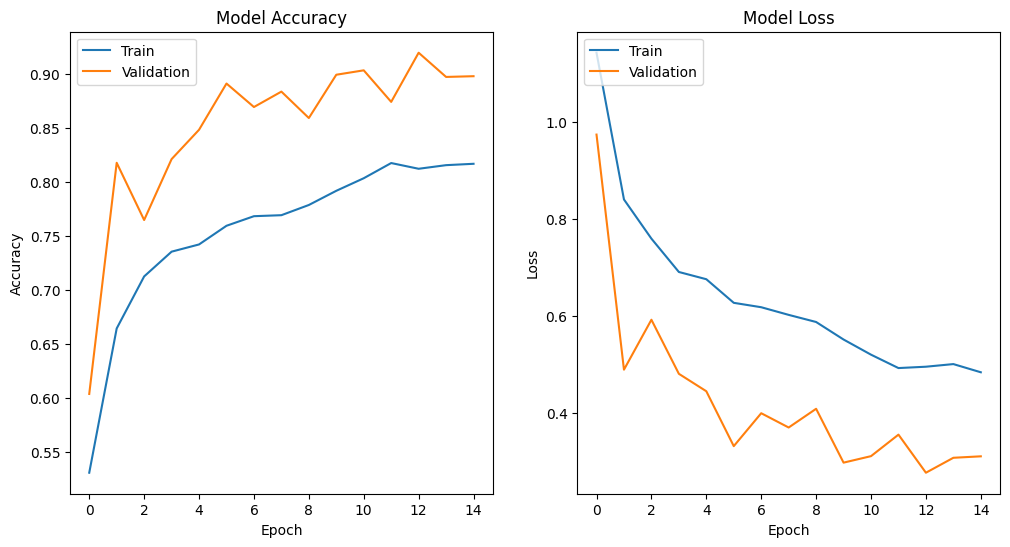

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [45]:
class_names = test_generator.class_indices.keys()
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=class_names)

71/71 [==============================] - 9s 119ms/step


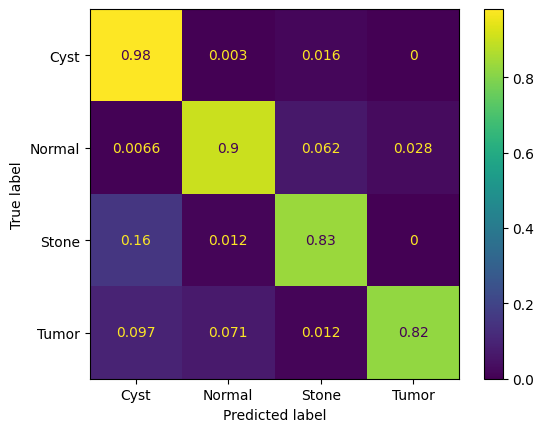

In [46]:
disp.plot()
plt.show()

In [47]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2

In [48]:
class_labels = list(class_names)

In [49]:
image_path = '/kaggle/working/test/Cyst/Cyst- (2569).jpg'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 1s 760ms/step
[[1. 0. 0. 0.]]


In [50]:
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class_label = class_labels[predicted_class_index[0]]
print(predicted_class_label)

Cyst
